# Report

In this notebook we report insurance cost

In [ ]:
# Ejecutar esta celda solo desde google colab
!git clone https://github.com/andres-soto-h/reto-regresion-ML1.git "/reto_ml_regresion"

%cd /reto_ml_regresion

In [1]:
import os
from functools import partial

In [2]:
import joblib
import pandas as pd

In [3]:
import data
import metrics

In [4]:
%load_ext autoreload
%autoreload 2

## Exploratory analysis

In [5]:
df_data= pd.read_csv('train_regression.csv', sep=',')

In [6]:
df_data.head(5)

,age,sex,bmi,children,smoker,region,y
0,43,female,25.080,0,no,northeast,7325.04820
1,39,male,35.300,2,yes,southwest,40103.89000
2,45,female,30.495,1,yes,northwest,39725.51805
3,19,female,32.900,0,no,southwest,1748.77400
4,60,male,39.900,0,yes,southwest,48173.36100


In [7]:
df_data.describe()

,age,bmi,children,y
count,896.000000,896.000000,896.000000,896.000000
mean,39.234375,30.542617,1.099330,13379.688250
std,14.212151,5.984036,1.205277,12110.713713
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.272500,0.000000,4819.842913
50%,39.000000,30.230000,1.000000,9556.297050
75%,52.000000,34.488750,2.000000,17092.916520
max,64.000000,53.130000,5.000000,62592.873090


In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       896 non-null    int64  
 1   sex       896 non-null    object 
 2   bmi       896 non-null    float64
 3   children  896 non-null    int64  
 4   smoker    896 non-null    object 
 5   region    896 non-null    object 
 6   y         896 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 49.1+ KB


Haciendo una revisión inicial de los datos se identifica que no hay valores nulos en el dataset.
La edad promedio para las personas incluidas en la base es de 39 años y el indice de masa corporal promedio es de 30 (por encima de lo normal y cercano a sobrepeso). El promedio de personas de la base tienen 1 hijo y el 75% de ellos tienen 2 o menos hijos.

In [9]:
df_data.age.quantile(q=[0.25, 0.50, 0.75], interpolation='midpoint')

0.25    27.0
0.50    39.0
0.75    52.0
Name: age, dtype: float64

In [10]:
def transform_age(age):
    if age <=32:
        return "[18 to 32]"
    elif age<=48:
        return "[33 to 48]"
    else:
        return "[older than 48]"

df_data['age_range'] = df_data['age'].apply(transform_age)

In [11]:
def transform_bmi(bmi):
    if bmi <=18.5:
        return "Underweight"
    elif bmi<=24.9:
        return "Healthy weight"
    elif bmi<=29.9:
        return "Overweight"
    else:
        return "Obesity"

df_data['bmi_range'] = df_data['bmi'].apply(transform_bmi)

In [12]:
dict_data = df_data[["age_range","bmi_range","y"]].groupby(["age_range","bmi_range"]).mean().to_dict()['y']

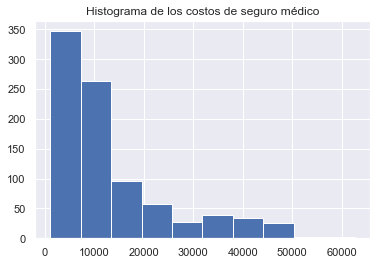

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

df_data.y.hist()
plt.title("Histograma de los costos de seguro médico");

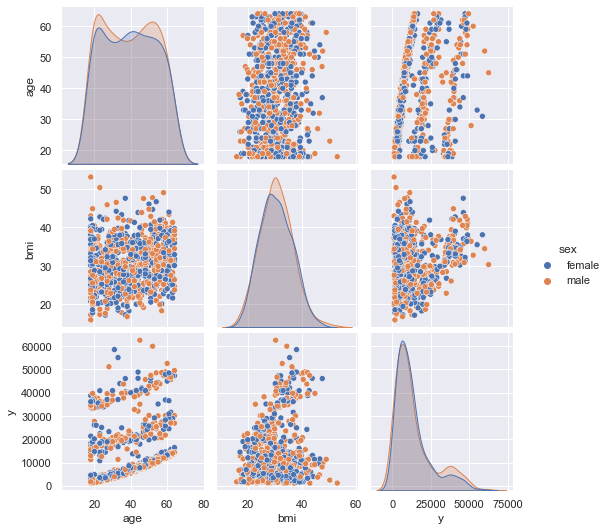

In [14]:
sns.pairplot(df_data.drop("children", axis=1), hue="sex");

Del anterior barplot comparativo, se puede determinar dos conclusiones principales: 

1) La primera de ellas, es que la característica sexo, no es un factor distintivo que permita segementar grupos poblacionales con relación al comportamiento de las demás variables, dado que las curvas de densidad describen curvas de densidad similares tanto para hombres como para mujeres. Sólo cabe resaltar, que los puntos de frecuencia más alta en los histogramas, sí tienen asociados puntos más altos para la población masculina.

2) De las variables analizadas, la edad parece tener una relación evidentemente lineal positiva con el valor del seguro. Adicionalmente, se observa una particularidad en esta relación, y es una separación de los datos en tres grupos.

C:\Users\Andre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


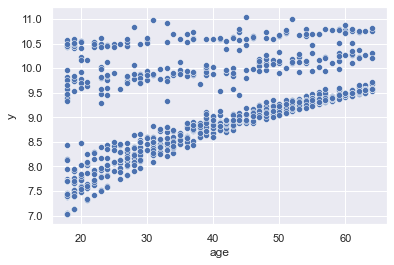

In [15]:
sns.scatterplot(df_data['age'], np.log(df_data['y']));

Realizando una normalización logarítima de los valores del costo de los seguros, se evidencia nuevamente las  3 agrupaciones de los datos al comparar la variable respuesta con la edad. La tendencia creciente en el valor del seguro se hace más evidente para los valores en escala logarítima de 7.0 a 9.5

C:\Users\Andre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


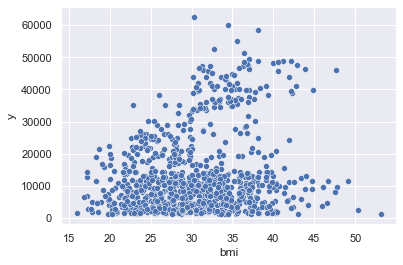

In [16]:
sns.scatterplot(df_data['bmi'], df_data['y']);

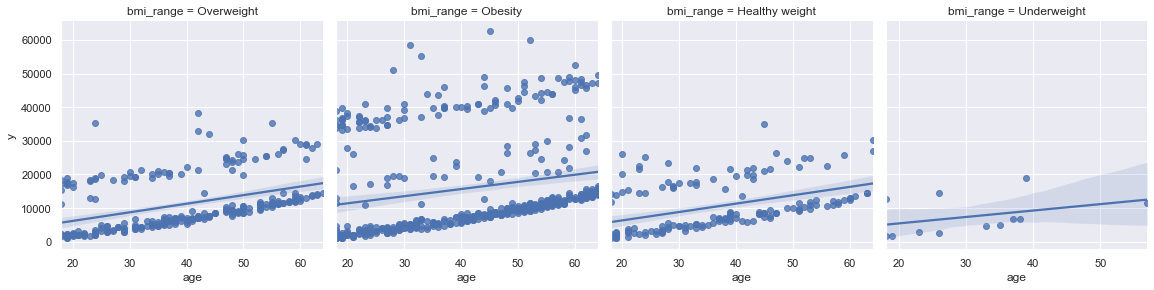

In [17]:
grid = sns.lmplot(x = "age", y = "y", col = "bmi_range", sharex=False, col_wrap = 4, data = df_data, height=4)

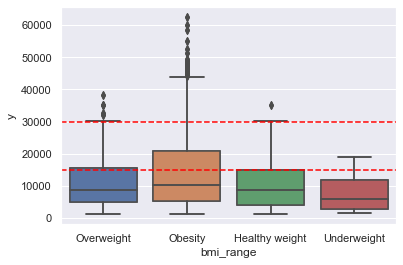

In [18]:
sns.boxplot(data=df_data, x= "bmi_range", y="y");sns.boxplot(data=df_data, x= "bmi_range", y="y")
plt.axhline(y=15000, c='red', linestyle = '--')
plt.axhline(y=30000, c='red', linestyle = '--');

Al analizar los valores del seguro por la característica de clasificación según el índice de masa corporal, la cual segmenta al individuo en:
- "Underweight" con bmi menores o iguales a 18.5
- "Healthy weight" para valores bmi entre (18.5,24.9]
- "Overweight" para valores bmi entre (24.9, 29.9]
- "Obesity con bmi mayores a 29.9

Se observa que al realizar la segmentación del índice de masa corporal se obtienen relaciones lineales mucho más marcadas que con el análsis de sólo el valor del índice. Adicional, no existe una diferencia significativa entre la distribución de los datos por tipo del rango del bmi, dado que el valor central de las cajas está al rededor de 10.000 y el q3 se mueve por debajo de los 15.000, excepto para el factor obesidad donde se tiene una mayor dispersión de los datos, con sesgo hacia la derecha y datos atípicos a partir del 45.000 aproximadamente.

C:\Users\Andre\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


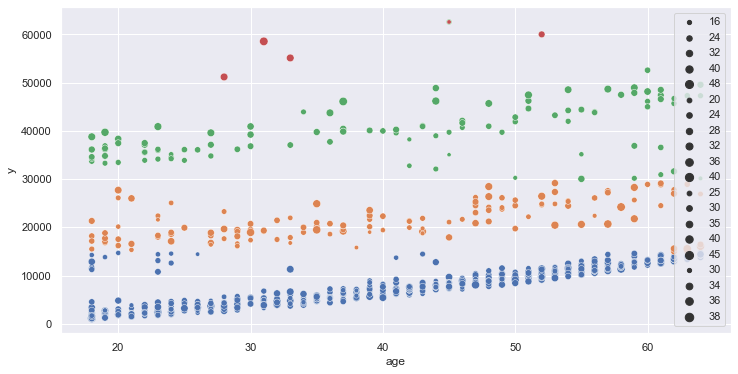

In [19]:
data1=df_data[df_data['y']<=15000]
data2=df_data[(df_data['y']>15000) & (df_data['y']<=30000)]
data3=df_data[df_data['y']>30000]

data1.bmi = data1.bmi.apply(lambda x : int(round(x)))
data2.bmi = data2.bmi.apply(lambda x : int(round(x)))
data3.bmi = data3.bmi.apply(lambda x : int(round(x)))

posible_outliers1 = df_data[(df_data['y']>50000) & (df_data['age']>20) & (df_data['age']<=30)]
posible_outliers2 = df_data[(df_data['y']>50000) & (df_data['age']>30) & (df_data['age']<60)]
posible_outliers = pd.concat([posible_outliers1, posible_outliers2])
posible_outliers.bmi = posible_outliers.bmi.apply(lambda x : int(round(x)))

plt.figure(figsize=(12,6))
sns.scatterplot(data=data1, x='age', y='y', size='bmi');
sns.scatterplot(data=data2, x='age', y='y', size='bmi');
sns.scatterplot(data=data3, x='age', y='y', size='bmi');
sns.scatterplot(data=posible_outliers, x='age', y='y', size='bmi');
plt.legend(loc='upper right');

In [20]:
#Eliminar posibles outliers del dataset 
data_so = df_data.drop(labels=list(posible_outliers.index), axis=0)
data_so.drop(columns=["bmi_range","age_range"], inplace=True)
data_so.to_csv("train_regression_so.csv",index=False)

In [21]:
df_data['sex'].value_counts()

male      459
female    437
Name: sex, dtype: int64

El dataset parece estar balanceado en términos del género de las personas

In [22]:
df_data['smoker'].value_counts()

no     708
yes    188
Name: smoker, dtype: int64

In [23]:
df_data['bmi_range'].value_counts()

Obesity           471
Overweight        261
Healthy weight    152
Underweight        12
Name: bmi_range, dtype: int64

Se tiene que del total de personas, 188 son fumadores, habrá que revisar si esta caracteristica se encuentra asociada con un mayor BMI y posiblemente mayores costos de atención.

In [24]:
df_data['region'].value_counts()

northeast    230
southeast    229
northwest    226
southwest    211
Name: region, dtype: int64

El dataset también se encuentra balanceado respecto a las regiones

In [25]:
df_data[['sex','y']].groupby('sex').mean()

,y
sex,
female,12943.455455
male,13795.012283


El costo promedio de atención para los hombres es un poco mas alto que para las mujeres

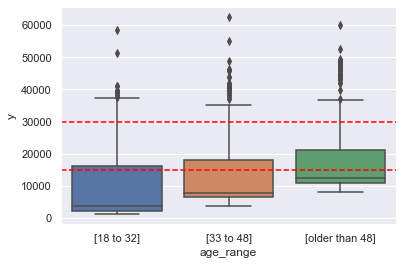

In [26]:
sns.boxplot(data=df_data, x= "age_range", y="y", order=['[18 to 32]','[33 to 48]','[older than 48]']);
plt.axhline(y=15000, c='red', linestyle = '--')
plt.axhline(y=30000, c='red', linestyle = '--');

In [27]:
df_data[['age_range','y']].groupby('age_range').aggregate(["mean", "std"])

y              
                         mean           std
age_range                                  
[18 to 32]        9854.424354  11839.537348
[33 to 48]       13103.636681  11496.050809
[older than 48]  17856.614094  11629.545999

como ya era evidente de análisis posteriores, ocurre un desplazamiento hacia arriba del valor promedio de los datos a medida que aumenta la edad. Pese a ello no es una característica enteramente discretizante puesto que los valores en cada grupo de edad se mueven en todo el rango de y.

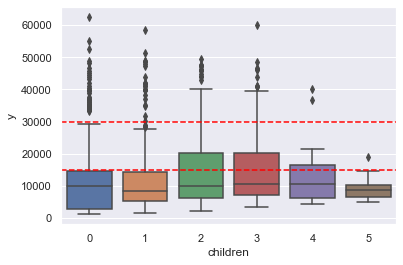

In [28]:
sns.boxplot(data=df_data, x= "children", y="y");
plt.axhline(y=15000, c='red', linestyle = '--')
plt.axhline(y=30000, c='red', linestyle = '--');

In [29]:
df_data.children.value_counts()

0    383
1    217
2    160
3    107
4     18
5     11
Name: children, dtype: int64

la cantidad de hijos no tiene un factor totalmente discretizante en la relación con el valor del seguro. Inclusive se evidencia una concentración de los datos en torno a la media para los valores de 4 y 5 hijos asociados a la poca cantidad de datos que caen en esta característica.

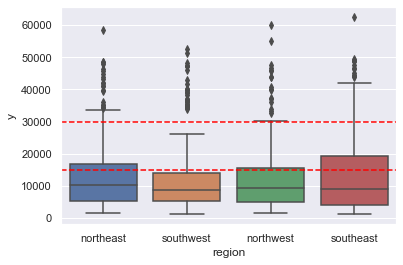

In [30]:
sns.boxplot(data=df_data, x= "region", y="y");
plt.axhline(y=15000, c='red', linestyle = '--')
plt.axhline(y=30000, c='red', linestyle = '--');

In [31]:
df_data[['region','y']].groupby('region').aggregate(["mean","median","std"])

y                           
                   mean       median           std
region                                            
northeast  13569.477583  10169.45420  11413.066300
northwest  12622.239959   9416.69425  11132.530892
southeast  14110.190502   9058.73030  13503.809564
southwest  13191.284228   8798.59300  12288.385230

Los valores promedio para el costo del seguro por región son similares entre sí, con una leve diferencia para la región de southeast.

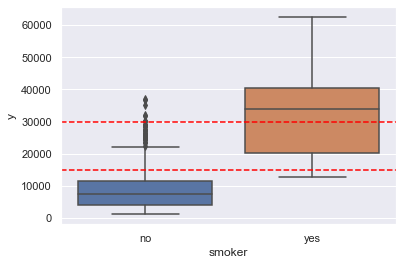

In [32]:
sns.boxplot(data=df_data, x= "smoker", y="y");
plt.axhline(y=15000, c='red', linestyle = '--')
plt.axhline(y=30000, c='red', linestyle = '--');

In [33]:
df_data[['smoker','y']].groupby('smoker').aggregate(["mean","median","std"])

y                           
                mean       median           std
smoker                                         
no       8510.527653   7430.26545   6056.013058
yes     31716.739861  34036.91050  11640.646109

Esta característica, parece tener íncidencia en la distribución de los valores de los seguros. Donde los no fumadores tienen una distribución asímetrica entre los cuartiles q1 y q3, con media y mediana cercanas entre sí, pero con un leve sesgo hacia la derecha en la franja de valores de seguro de 1.500 y 3.000. Se da un desplazamiento en los valores del seguro para las personas fumadoras, con datos no asímetricos en el 50% de sus valores con mediana de 34.036 y media de 31.716 aproximadamente. 

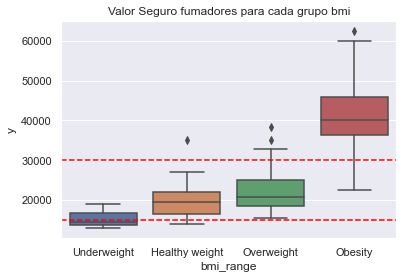

In [34]:
data_smoker = df_data[df_data.smoker == 'yes']
sns.boxplot(data=data_smoker, x= "bmi_range", y="y", order=["Underweight", 'Healthy weight','Overweight','Obesity'])
plt.axhline(y=15000, c='red', linestyle = '--')
plt.axhline(y=30000, c='red', linestyle = '--')
plt.title('Valor Seguro fumadores para cada grupo bmi');

In [35]:
data_smoker_obesity = data_smoker[data_smoker.bmi_range == 'Obesity']

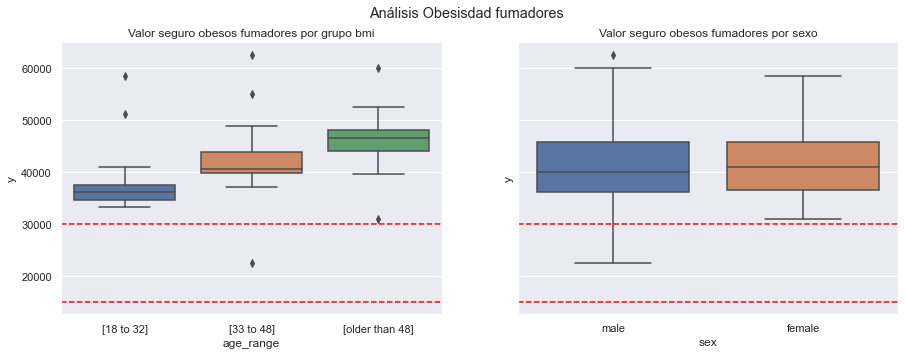

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Análisis Obesisdad fumadores')

sns.boxplot(ax=axes[0],data=data_smoker_obesity, x= "age_range", y="y",order=['[18 to 32]','[33 to 48]','[older than 48]'])
axes[0].set_title('Valor seguro obesos fumadores por grupo bmi')
axes[0].axhline(y=15000, c='red', linestyle = '--')
axes[0].axhline(y=30000, c='red', linestyle = '--')

sns.boxplot(ax=axes[1],data=data_smoker_obesity, x= "sex", y="y")
axes[1].set_title('Valor seguro obesos fumadores por sexo')
axes[1].axhline(y=15000, c='red', linestyle = '--')
axes[1].axhline(y=30000, c='red', linestyle = '--');

Text(0.5, 1.0, 'Valor Seguro no fumadores para cada grupo bmi')

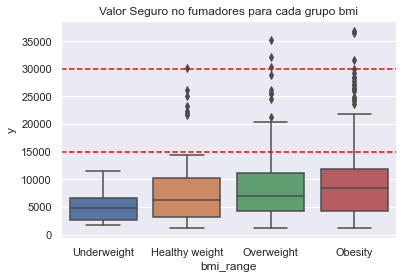

In [37]:
data_not_smoker = df_data[df_data.smoker == 'no']
sns.boxplot(data=data_not_smoker, x= "bmi_range", y="y", order=["Underweight", 'Healthy weight','Overweight','Obesity']);
plt.axhline(y=15000, c='red', linestyle = '--')
plt.axhline(y=30000, c='red', linestyle = '--')
plt.title('Valor Seguro no fumadores para cada grupo bmi')

In [38]:
data_notsmoker_obesity = data_not_smoker[data_not_smoker.bmi_range == 'Obesity']

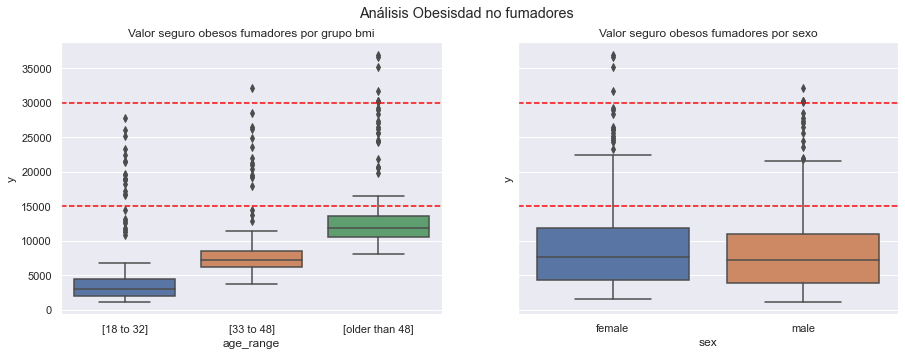

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Análisis Obesisdad no fumadores')

sns.boxplot(ax=axes[0],data=data_not_smoker, x= "age_range", y="y",order=['[18 to 32]','[33 to 48]','[older than 48]'])
axes[0].set_title('Valor seguro obesos fumadores por grupo bmi')
axes[0].axhline(y=15000, c='red', linestyle = '--')
axes[0].axhline(y=30000, c='red', linestyle = '--')

sns.boxplot(ax=axes[1],data=data_not_smoker, x= "sex", y="y")
axes[1].set_title('Valor seguro obesos fumadores por sexo')
axes[1].axhline(y=15000, c='red', linestyle = '--')
axes[1].axhline(y=30000, c='red', linestyle = '--');

## MODEL

In [40]:
def evaluate_model(*, model, metric, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    train_error = metric(y_train, train_predictions)
    test_error = metric(y_test, test_predictions)
    return {
        "train_predictions": train_predictions,
        "test_predictions": test_predictions,
        "train_error": train_error,
        "test_error": test_error
    }

def print_report(*, model, evaluation):
    print(f"Model used:\n\t{reg}")
    print(f"Error:\n\ttrain set {evaluation['train_error']}\n\ttest error: {evaluation['test_error']}")

In [41]:
models_dir = "models"

In [42]:
dataset_path = "train_regression.csv"

In [43]:
dataset = data.get_dataset(
    partial(pd.read_csv, filepath_or_buffer=dataset_path),
    splits=("train", "test")
)

In [44]:
dataset

{'train': (     age     sex     bmi  children smoker     region        age_range  \
  881   38  female  19.475         2     no  northwest       [33 to 48]   
  789   48  female  28.900         0     no  southwest       [33 to 48]   
  602   30    male  37.430         3     no  northeast       [18 to 32]   
  786   33  female  24.310         0     no  southeast       [33 to 48]   
  669   57  female  28.700         0     no  southwest  [older than 48]   
  ..   ...     ...     ...       ...    ...        ...              ...   
  258   62  female  31.730         0     no  northeast  [older than 48]   
  152   42    male  31.255         0     no  northwest       [33 to 48]   
  397   52    male  34.485         3    yes  northwest  [older than 48]   
  71    46    male  39.425         1     no  northeast       [33 to 48]   
  608   53  female  23.750         2     no  northeast  [older than 48]   
  
            bmi_range  
  881  Healthy weight  
  789      Overweight  
  602         Ob

## Baseline


In [45]:
model_path = os.path.join("models", "2021-06-10 16-20", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('average-price-per-bmi-regressor',
                 AveragePricePerBMIRegressor())])
Error:
	train set 8757.69126149081
	test error: 9692.9846746485


## Linear Regression Model 


In [46]:
model_path = os.path.join("models", "2021-06-10 20-18", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('linear-regressor', LinearRegression())])
Error:
	train set 4241.133955127506
	test error: 4331.7453896886955


## Linear regression with Feature Engineering


In [47]:
model_path = os.path.join("models", "2021-06-12 20-54", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures(interaction_only=True)),
                ('standard-scaler', StandardScaler()),
                ('linear-regressor', LinearRegression())])
Error:
	train set 2998.2632266520664
	test error: 3108.872120578847


In [48]:
model_path = os.path.join("models", "2021-06-12 20-54", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures(interaction_only=True)),
                ('standard-scaler', StandardScaler()),
                ('linear-regressor', LinearRegression())])
Error:
	train set 0.8317587737718674
	test error: 0.8438556548658451


## Random Forest


In [49]:
model_path = os.path.join("models", "2021-06-10 21-00", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('random-forest-regressor',
                 RandomForestRegressor(max_depth=3, min_samples_split=6,
                                       n_estimators=150))])
Error:
	train set 2658.1115624491663
	test error: 2874.606701526063


In [50]:
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('random-forest-regressor',
                 RandomForestRegressor(max_depth=3, min_samples_split=6,
                                       n_estimators=150))])
Error:
	train set 0.8584824990235743
	test error: 0.8678502250420668


## Gradient Boosting

In [51]:
model_path = os.path.join("models", "2021-06-10 20-54", "model.joblib")

reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('gradient-boosting-regressor',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=130,
                                           subsample=1))])
Error:
	train set 2298.0254363635067
	test error: 2449.2808709352125


In [52]:
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('gradient-boosting-regressor',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=130,
                                           subsample=1))])
Error:
	train set 0.8913710207701334
	test error: 0.8882011923633542


## Stacking

In [53]:
model_path = os.path.join("models", "2021-06-10 22-46", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('stacking-regressor',
                 StackingRegressor(estimators=[('lr', Ridge()),
                                               ('dt', DecisionTreeRegressor())],
                                   final_estimator=RandomForestRegressor(max_depth=3,
                                                                         min_samples_split=6,
                                                                         n_estimators=150)))])
Error:
	train set 2753.4182093417708
	test error: 2798.789127807134


In [54]:
evaluation = evaluate_model(
    model=reg,
    metric=metrics.r2_score,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('standard-scaler', StandardScaler()),
                ('stacking-regressor',
                 StackingRegressor(estimators=[('lr', Ridge()),
                                               ('dt', DecisionTreeRegressor())],
                                   final_estimator=RandomForestRegressor(max_depth=3,
                                                                         min_samples_split=6,
                                                                         n_estimators=150)))])
Error:
	train set 0.8577023207063226
	test error: 0.8743546910094405


## Gradient Boosting with feature Engineering

In [55]:
model_path = os.path.join("models", "2021-06-14 03-35", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=dataset["train"][0],
    y_train=dataset["train"][1],
    X_test=dataset["test"][0],
    y_test=dataset["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures(interaction_only=True)),
                ('standard-scaler', StandardScaler()),
                ('gradient-boosting-regressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=2,
                                           n_estimators=145))])
Error:
	train set 2173.618938275774
	test error: 2453.216644868914


In [56]:
X_test_reto = pd.read_csv("test_regression_students.csv", sep=",")
X_test_reto["y"]=0
X_test_reto.to_csv("test_regression_students_y.csv",index=False)

In [57]:
dataset_path = "test_regression_students_y.csv"

dataset_reto = data.get_dataset_mod(
    partial(pd.read_csv, filepath_or_buffer=dataset_path),
    splits=("train", "test")
)

In [58]:
model = joblib.load(model_path)

X_test_reto=dataset_reto["test"][0]

In [59]:
test_predictions = model.predict(X_test_reto)

In [60]:
test_predictions.shape

(442,)

In [61]:
import requests
import json

In [62]:
URL = "https://qzbbjszmjk.execute-api.us-east-1.amazonaws.com/dev"

results = {"id": "ALEJANDRO JARAMILLO MIRA; CAROLINA GARCÍA PATIÑO; JUAN PABLO GUTIÉRREZ MURIEL; ROBIN ANDRES SOTO HINCAPIE","email": "alejandro.jaramillom@udea.edu.co", "task_type": "Regression" ,"predictions": list(test_predictions)}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

#Quitar comentaro para enviar modelo
#r = requests.post(url= URL+"/benchmarkin/", data = json.dumps(results) , headers=headers)


In [63]:
#r.text

## Error analysis

In [64]:
X_test = dataset["test"][0].reset_index()
y_true = dataset["test"][1].reset_index()["y"]
y_pred = pd.Series(evaluation["test_predictions"], name="Prediction")

In [65]:
pred_data=X_test.join([y_true , y_pred])

In [66]:
pred_data["error"]=np.abs(pred_data["y"]-pred_data["Prediction"])

In [67]:
error_data = pred_data.sort_values(by=["error"], ascending=False).head(30)

error_data.sort_values(by=["error"], ascending=False)

,index,age,sex,bmi,children,smoker,region,age_range,bmi_range,y,Prediction,error
255,6,55,female,26.800,1,no,southwest,[older than 48],Overweight,35160.13457,13278.492581,21881.641989
21,518,59,female,34.800,2,no,southwest,[older than 48],Obesity,36910.60803,18261.053176,18649.554854
77,559,18,female,30.115,0,no,northeast,[18 to 32],Obesity,21344.84670,3959.919845,17384.926855
218,354,28,female,24.320,1,no,northeast,[18 to 32],Healthy weight,23288.92840,6520.842511,16768.085889
100,548,33,female,35.530,0,yes,northwest,[33 to 48],Obesity,55135.40209,38836.232131,16299.169959
86,229,53,male,31.350,0,no,southeast,[older than 48],Obesity,27346.04207,11903.339342,15442.702728
61,424,23,male,18.715,0,no,northwest,[18 to 32],Healthy weight,21595.38229,6313.404632,15281.977658
158,394,39,male,34.100,2,no,southeast,[33 to 48],Obesity,23563.01618,8745.154823,14817.861357
80,216,60,female,25.840,0,no,northwest,[older than 48],Overweight,28923.13692,14534.985768,14388.151152
32,837,37,male,29.800,0,no,southwest,[33 to 48],Overweight,20420.60465,6202.530937,14218.073713


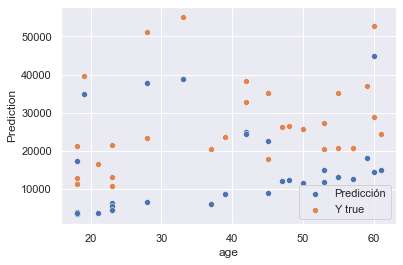

In [68]:
sns.scatterplot(data=error_data, x="age", y="Prediction", label="Predicción");
sns.scatterplot(data=error_data, x="age", y="y", label="Y true");

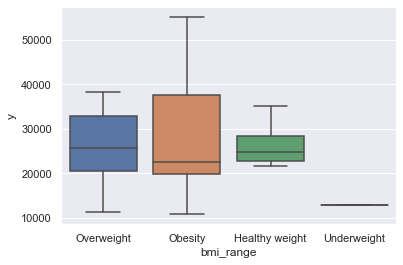

In [69]:
sns.boxplot(data=error_data, x= "bmi_range", y="y");

In [70]:
error_data["bmi_range"].value_counts()

Obesity           16
Overweight         9
Healthy weight     4
Underweight        1
Name: bmi_range, dtype: int64

In [71]:
error_data["age_range"].value_counts()

[18 to 32]         11
[older than 48]    10
[33 to 48]          9
Name: age_range, dtype: int64

In [72]:
error_data["smoker"].value_counts()

no     22
yes     8
Name: smoker, dtype: int64

In [73]:
error_data["children"].value_counts()

0    18
1     7
2     3
3     2
Name: children, dtype: int64

In [74]:
from sklearn.cluster import KMeans

## Modelo de votación agrupando los datos por rango de costo y edad

In [75]:

data_cluster=df_data.copy()
data_cluster.drop(["y", "age_range", "bmi_range"], axis=1, inplace=True)


data_cluster = pd.get_dummies(data_cluster, columns=["sex", "smoker", "region"], prefix=["sex", "smoker", "region"])

model = KMeans(n_clusters=3)
model.fit(data_cluster)

# Prediction on the entire data
all_predictions = pd.Series(model.predict(data_cluster), name="class")

In [76]:
data_cluster2 = data_cluster.join([all_predictions,df_data["y"]])

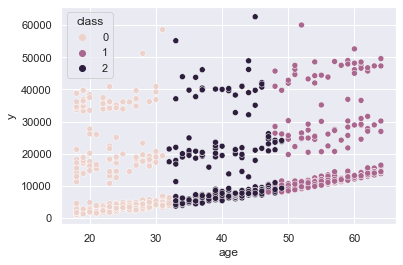

In [77]:


sns.scatterplot(data=data_cluster2, x='age', y='y', hue="class");


In [78]:
data1=df_data[(df_data['y']<=9000) & (df_data['age']<=32)]
data2=df_data[(df_data['y']>9000) & (df_data['y'] <= 30000) & (df_data['age']<=32)]
data3=df_data[(df_data['y']>30000) &  (df_data['y']<50000)  & (df_data['age']<=32)]

data4=df_data[(df_data['y']<=12000) & (df_data['age'] > 32) & (df_data['age']<=48)]
data5=df_data[(df_data['y']>12000) & (df_data['y'] <= 30000) & (df_data['age'] > 32) & (df_data['age']<=48)]
data6=df_data[(df_data['y']>30000) & (df_data['y']<50000)  & (df_data['age'] > 32) & (df_data['age']<=48)]

data7=df_data[(df_data['y']<=19000) & (df_data['age']> 48)]
data8=df_data[(df_data['y']>19000) & (df_data['y'] <= 35000) & (df_data['age']>48)]
data9=df_data[(df_data['y']>35000) & (df_data['y']<50000)  & (df_data['age']>48)]

data_m1 = pd.concat([data1, data4, data7])
data_m2 = pd.concat([data2, data5, data8])
data_m3 = pd.concat([data3, data6, data9])

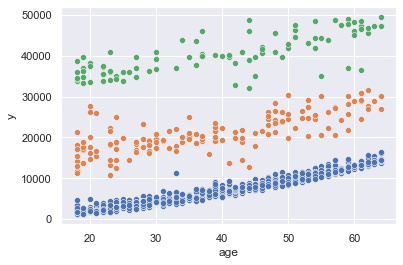

In [79]:
sns.scatterplot(data=data_m1, x='age', y='y');
sns.scatterplot(data=data_m2, x='age', y='y');
sns.scatterplot(data=data_m3, x='age', y='y');

In [80]:
X_m1 = pd.get_dummies(data_m1.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])

X_m2 = pd.get_dummies(data_m2.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])

X_m3 = pd.get_dummies(data_m3.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])

In [81]:
y_m1=data_m1["y"]
y_m2=data_m2["y"]
y_m3=data_m3["y"]

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

In [83]:
# MODELO 1 
X_train, X_test, y_train, y_test = train_test_split(X_m1, y_m1, test_size=0.2, random_state=42)

regr1 = RandomForestRegressor(max_depth=4)
regr1.fit(X_train, y_train)

score_train = regr1.score(X_train, y_train)
score_test = regr1.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.9797631490015055
Test score: 0.9784700705643359


In [84]:
# MODELO 2
X_train, X_test, y_train, y_test = train_test_split(X_m2, y_m2, test_size=0.2, random_state=42)

regr = RandomForestRegressor()
regr.fit(X_train, y_train)

score_train = regr.score(X_train, y_train)
score_test = regr.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.9318147619475841
Test score: 0.638506560599246


In [85]:
# MODELO 2.1

regr2=make_pipeline(PolynomialFeatures(3),RandomForestRegressor(max_depth=5))
regr2.fit(X_train, y_train)

score_train = regr2.score(X_train, y_train)
score_test = regr2.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.8816245423359351
Test score: 0.6551288359907659


In [86]:
# MODELO 3
X_train, X_test, y_train, y_test = train_test_split(X_m3, y_m3, test_size=0.2, random_state=42)

regr3=make_pipeline(PolynomialFeatures(4),RandomForestRegressor(max_depth=5))
regr3.fit(X_train, y_train)

score_train = regr3.score(X_train, y_train)
score_test = regr3.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.979485531543397
Test score: 0.9403716665420361


In [87]:
X_ = pd.get_dummies(df_data.drop(columns=["y"]), columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])
y_ = df_data["y"]

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

er = VotingRegressor([('m1', regr1), ('m2', regr2), ('m3', regr3)])
er.fit(X_train, y_train)

score_train = er.score(X_train, y_train)
score_test = er.score(X_test, y_test)

print(f"Train score: {score_train}")
print(f"Test score: {score_test}")

Train score: 0.90319675333107
Test score: 0.8531149256028374


In [88]:
X_test_reto2 = pd.get_dummies(X_test_reto, columns=["sex", "smoker", "region", "age_range", "bmi_range"], prefix=["sex", "smoker", "region","age_range", "bmi_range"])
test_predictions2 = er.predict(X_test_reto2)

In [89]:
test_predictions2.shape

(442,)

In [90]:
results = {"id": "ALEJANDRO JARAMILLO MIRA; CAROLINA GARCÍA PATIÑO; JUAN PABLO GUTIÉRREZ MURIEL; ROBIN ANDRES SOTO HINCAPIE","email": "robin.soto@udea.edu.co", "task_type": "Regression" ,"predictions": list(test_predictions2)}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

#r = requests.post(url= URL+"/benchmarkin/", data = json.dumps(results) , headers=headers)

In [91]:
#r.text